In [1]:
using StateSpaceDynamics, Plots

In [2]:
model = initialize_slds()

SwitchingLinearDynamicalSystem([0.96 0.04; 0.04 0.96], StateSpaceDynamics.LinearDynamicalSystem[StateSpaceDynamics.LinearDynamicalSystem{StateSpaceDynamics.GaussianStateModel{Float64}, StateSpaceDynamics.GaussianObservationModel{Float64}}(StateSpaceDynamics.GaussianStateModel{Float64}([0.9452539570141245 -0.09484174581448675; 0.09484174581448675 0.9452539570141245], [0.001 0.0; 0.0 0.001], [0.0, 0.0], [0.001 0.0; 0.0 0.001]), StateSpaceDynamics.GaussianObservationModel{Float64}([-0.31498797116895605 0.4338858743048611; -0.31125240132442067 -0.3954398407537453; … ; -0.8253345499750688 -0.9654904870197227; 0.840288523245819 0.9656607495563969], [0.001 0.0 … 0.0 0.0; 0.0 0.001 … 0.0 0.0; … ; 0.0 0.0 … 0.001 0.0; 0.0 0.0 … 0.0 0.001]), 2, 10, Bool[1, 1, 1, 1, 1, 1]), StateSpaceDynamics.LinearDynamicalSystem{StateSpaceDynamics.GaussianStateModel{Float64}, StateSpaceDynamics.GaussianObservationModel{Float64}}(StateSpaceDynamics.GaussianStateModel{Float64}([-0.39533949471978524 -0.86383255548

In [3]:
T = 1000
# Generate synthetic data
x, y, z = sample(model, T)


([0.012781148406102944 -0.043551433682513074 … 0.00918994518478555 0.032159415587346474; 0.03788281101630884 -0.021698572664429976 … -0.08498702535863967 -0.10696223889695364], [-0.0037362031674817928 0.011184638740456908 … -0.07094318488635357 -0.050323491624458885; 0.01979088919057409 0.030620168627788776 … 0.030785185388674228 0.0675583423786563; … ; -0.06176123606409473 0.086548578688241 … 0.137359927485125 0.03213684839745746; 0.042094688716242876 -0.10110240825174423 … -0.06636174473552493 -0.08508079724902803], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

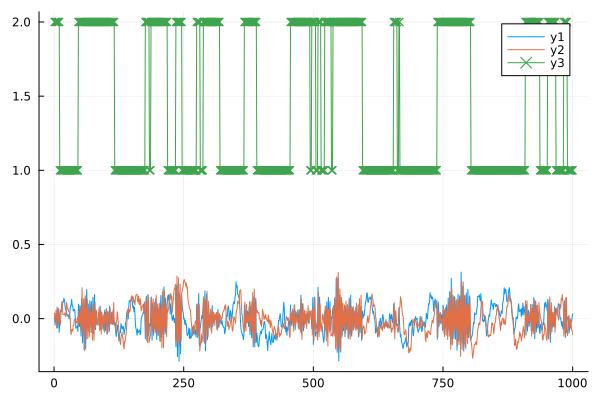

In [4]:
plot(x')
plot!(z, marker=:x)

In [5]:
using LinearAlgebra

p = model.B[1].obs_dim
d = model.B[1].latent_dim

K = model.K
A = rand(K, K)
A ./= sum(A, dims=2) # Normalize rows to sum to 1

πₖ = rand(K)
πₖ ./= sum(πₖ) # Normalize to sum to 1

Q = Matrix(0.5 * I(d))

x0 = [0.0; 0.0]
P0 = Matrix(0.5 * I(d))

# set up the observation parameters
C = randn(p, d)
R = Matrix(0.001 * I(p))

B = [StateSpaceDynamics.LinearDynamicalSystem(
    StateSpaceDynamics.GaussianStateModel(0.95 * [cos(f) -sin(f); sin(f) cos(f)], Q, x0, P0),
    StateSpaceDynamics.GaussianObservationModel(C, R),
    d, p, fill(true, 6  )) for (i,f) in zip(1:K, [0.5, 0.5])]

modeli = SwitchingLinearDynamicalSystem(A, B, πₖ, model.K)

SwitchingLinearDynamicalSystem([0.954138974915903 0.04586102508409695; 0.8845992124331765 0.11540078756682351], StateSpaceDynamics.LinearDynamicalSystem[StateSpaceDynamics.LinearDynamicalSystem{StateSpaceDynamics.GaussianStateModel{Float64}, StateSpaceDynamics.GaussianObservationModel{Float64}}(StateSpaceDynamics.GaussianStateModel{Float64}([0.8337034337958541 -0.45545426167399283; 0.45545426167399283 0.8337034337958541], [0.5 0.0; 0.0 0.5], [0.0, 0.0], [0.5 0.0; 0.0 0.5]), StateSpaceDynamics.GaussianObservationModel{Float64}([-2.3114219965706413 -1.3145381337792914; -0.33259642172623743 0.3711950932577804; … ; 1.692488588090618 1.372914975753027; 1.538173625787169 -1.2002750049480275], [0.001 0.0 … 0.0 0.0; 0.0 0.001 … 0.0 0.0; … ; 0.0 0.0 … 0.001 0.0; 0.0 0.0 … 0.0 0.001]), 2, 10, Bool[1, 1, 1, 1, 1, 1]), StateSpaceDynamics.LinearDynamicalSystem{StateSpaceDynamics.GaussianStateModel{Float64}, StateSpaceDynamics.GaussianObservationModel{Float64}}(StateSpaceDynamics.GaussianStateModel{

In [6]:
FB = StateSpaceDynamics.initialize_forward_backward(modeli, T)
FS = [StateSpaceDynamics.initialize_FilterSmooth(modeli.B[k], T) for k in 1:K]

ml = variational_expectation!(modeli, y, FB, FS)

# ml = zeros(100,1)
# for i in 1:length(ml)
#     ml[i] = variational_expectation!(modeli, y, FB, FS)  
# end

-154278.0008342356

-154278.0008342356

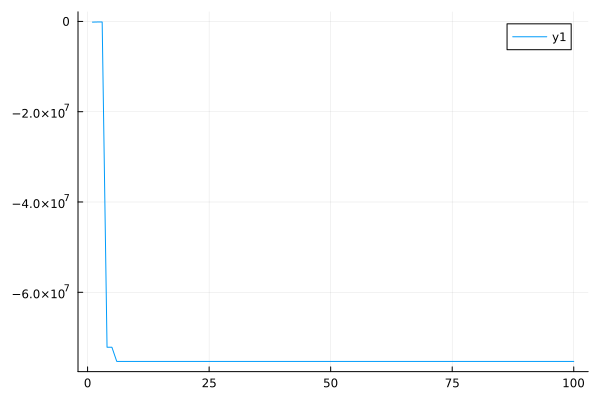

In [7]:
plot(ml)

In [6]:
mls, param_diff, FB, FS = fit!(modeli, y; max_iter=100)

BoundsError: BoundsError: attempt to access 1-element Vector{Any} at index [-1]

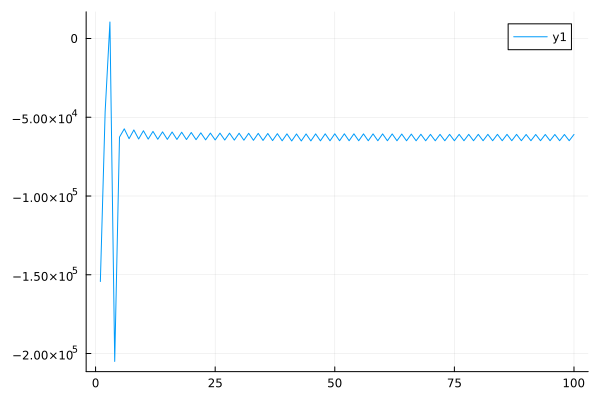

In [9]:
plot(mls)

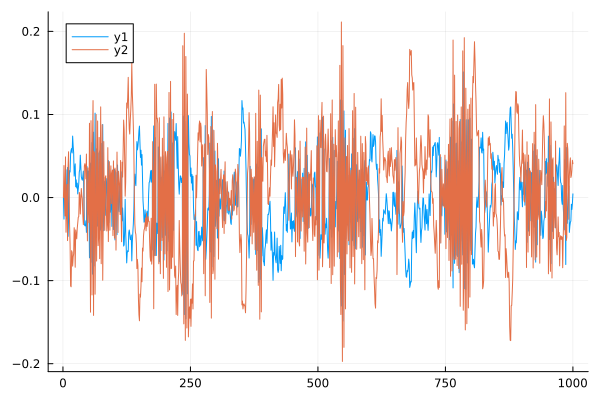

In [8]:
plot(FS[1].x_smooth')

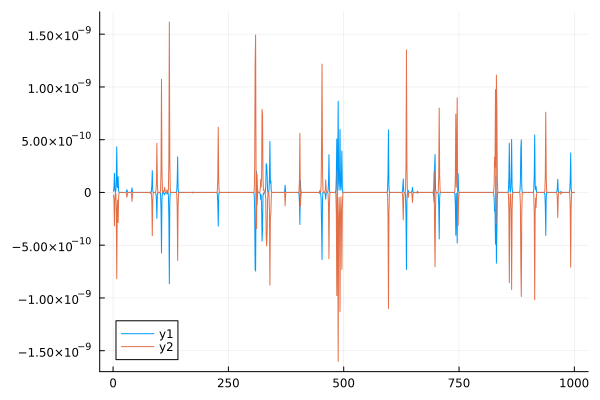

In [9]:
plot(FS[2].x_smooth')

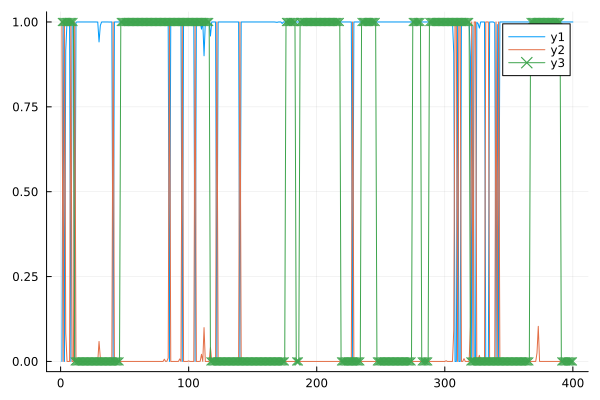

In [10]:
plot(exp.(FB.γ[:,1:400])')
plot!(z[1:400] .- 1, marker=:x)

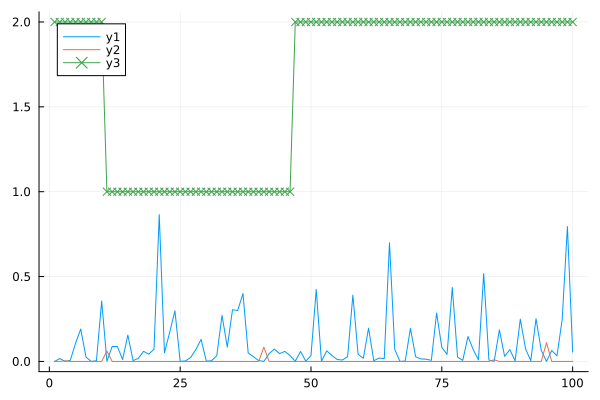

In [11]:
plot(exp.(FB.loglikelihoods[:,1:100])')
plot!(z[1:100], marker=:x)

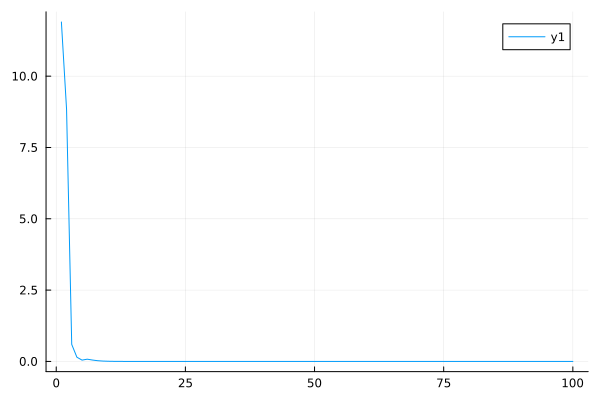

In [12]:
plot(param_diff)